<a href="https://colab.research.google.com/github/Paul-mwaura/Programming-PyTorch-for-Deep-Learning/blob/main/Classifying_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Fashion MNIST

In [93]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix

In [94]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = "retina"


In [95]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Dowmload and load the training data
trainset = datasets.FashionMNIST('-/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('-/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [96]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10)

    # Dropout module with 0.2(20%) drop probability.
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, x):
    # make sure tensor is flattened.
    x = x.view(x.shape[0], -1) # Flattening the tensor.

    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))

    # Output without a dropout.
    x = F.log_softmax(self.fc4(x), dim=1)

    return x

## Train the network
Our network process will include the following.
* make a forward pass through the network to get the logits.
* use the logits to calculate the loss.
* perform a backward pass through the network with loss.backward() to calculate the gradients.
* take a step with the optimizer to update the weights.

In [97]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [98]:
# Train the network.
epochs = 10
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
  running_loss = 0
  for images, labels in train_loader:

    optimizer.zero_grad()

    logps = model(images)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0

    # turn off gradients for validation, saves memory and computations
    with torch.no_grad():
      # set model to evaluation mode
      model.eval()

      for images, labels in testloader:
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

    # set model back to train mode
    model.train()

    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test Loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}..".format(accuracy/len(testloader)))

Epoch: 1/10.. Training loss: 0.603.. Test Loss: 0.476.. Test Accuracy: 0.827..
Epoch: 2/10.. Training loss: 0.487.. Test Loss: 0.457.. Test Accuracy: 0.836..
Epoch: 3/10.. Training loss: 0.445.. Test Loss: 0.420.. Test Accuracy: 0.851..
Epoch: 4/10.. Training loss: 0.435.. Test Loss: 0.424.. Test Accuracy: 0.849..
Epoch: 5/10.. Training loss: 0.418.. Test Loss: 0.404.. Test Accuracy: 0.862..
Epoch: 6/10.. Training loss: 0.409.. Test Loss: 0.404.. Test Accuracy: 0.858..
Epoch: 7/10.. Training loss: 0.411.. Test Loss: 0.398.. Test Accuracy: 0.861..
Epoch: 8/10.. Training loss: 0.398.. Test Loss: 0.389.. Test Accuracy: 0.861..
Epoch: 9/10.. Training loss: 0.392.. Test Loss: 0.394.. Test Accuracy: 0.860..
Epoch: 10/10.. Training loss: 0.389.. Test Loss: 0.394.. Test Accuracy: 0.863..


## Inference and Validation

In [99]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)


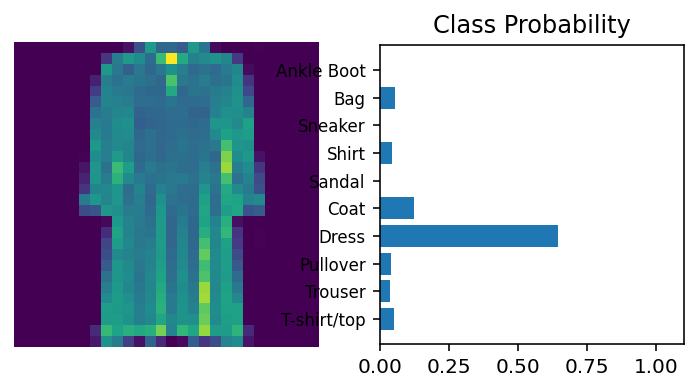

In [100]:
# Test the network

dataiter = iter(val_loader)
images, labels = dataiter.next()
img = images[1]

# Calculate the class probabilities (softmax) for img
ps = torch.exp(model(img))

# plot image and probabilities
view_classify(img, ps, version='Fashion')

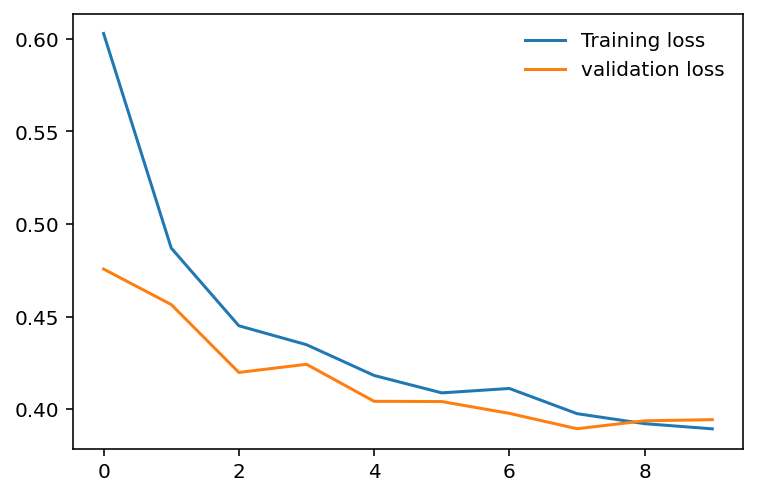

In [101]:
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="validation loss")
plt.legend(frameon=False)

In [102]:
print(top_p[:10, :])

tensor([[0.7569],
        [0.7096],
        [0.6786],
        [0.4688],
        [1.0000],
        [0.9881],
        [0.6299],
        [0.9939],
        [1.0000],
        [0.9994]])


In [103]:
equals[:10]

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [104]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f"Accuracy {accuracy.item()*100}%")

Accuracy 100.0%


## Saving and Loading the Model

In [105]:
print(f"Our model: \n\n {model}\n")
print(f"the state dict keys: \n\n{model.state_dict().keys()}")

Our model: 

 Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

the state dict keys: 

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [106]:
torch.save(model.state_dict(), "checkpoint.pth")

In [107]:
state_dict = torch.load("checkpoint.pth")
print(state_dict.keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [108]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [109]:
print(model)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


Loading the state dict works only if the model architecture is exactly the same as the checkpoint architecture. If I create a model with a different architecture, it will fail.
The model has to have exactly similar shapes.